<a href="https://colab.research.google.com/github/asharasjad/ApplyFast/blob/main/PyTorch_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision

In [ ]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.8.0+cu126
torchvision version: 0.23.0+cu126


#### **COMPUTER VISION LIBRARIES IN TORCH**



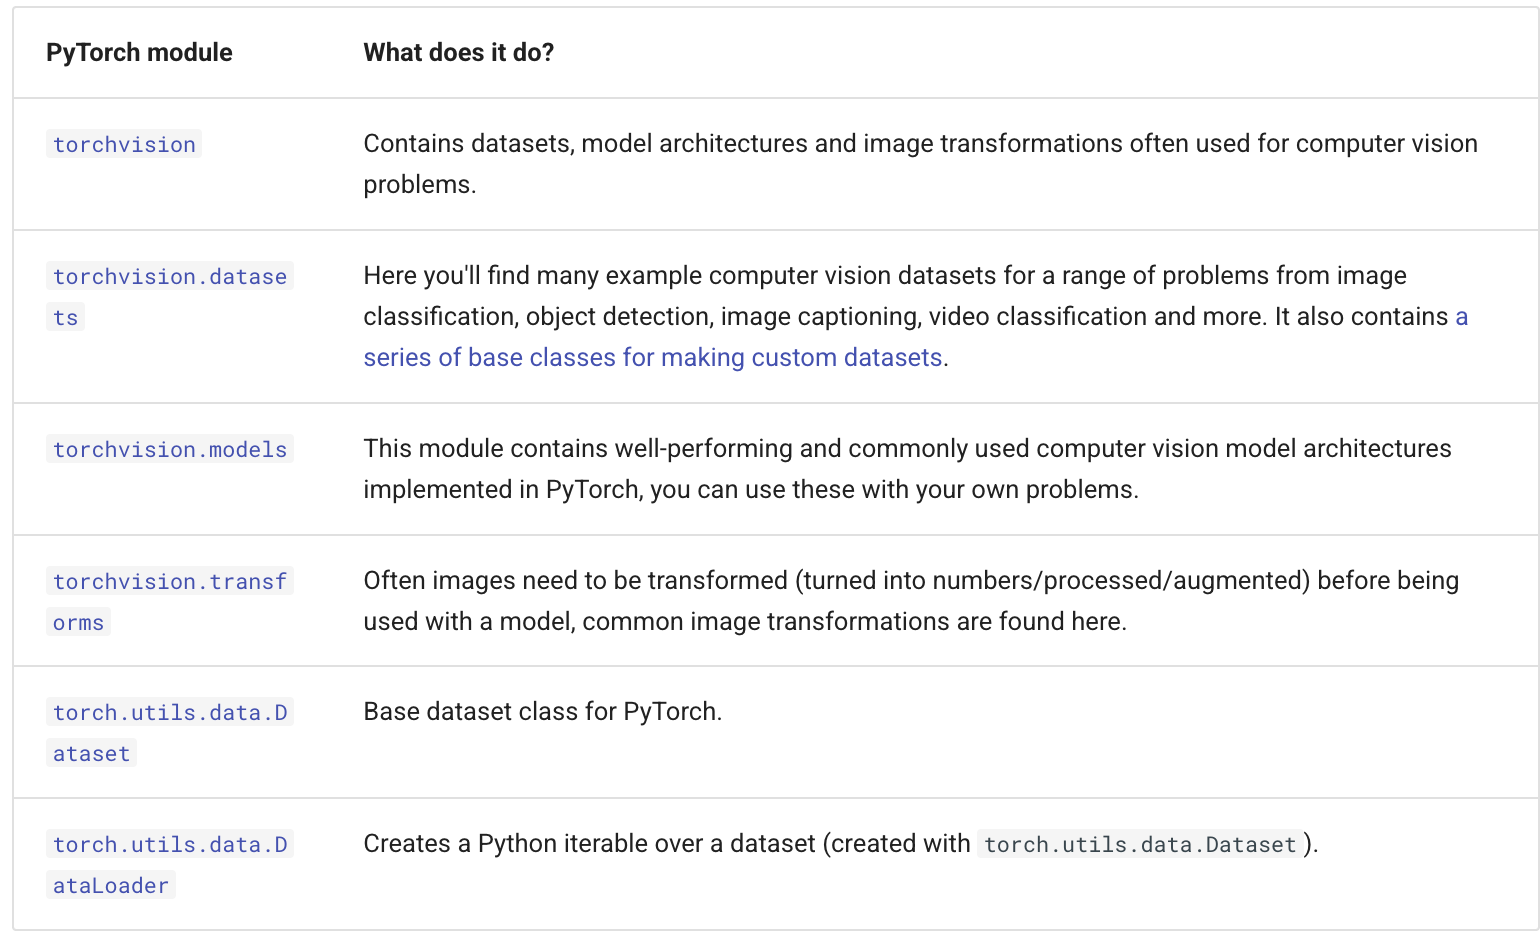

## 1) Getting The Data Set

We're going to start with FashionMNIST.

MNIST stands for Modified National Institute of Standards and Technology.

The original MNIST dataset contains thousands of examples of handwritten digits (from 0 to 9) and was used to build computer vision models to identify numbers for postal services.

FashionMNIST, made by Zalando Research, is a similar setup.

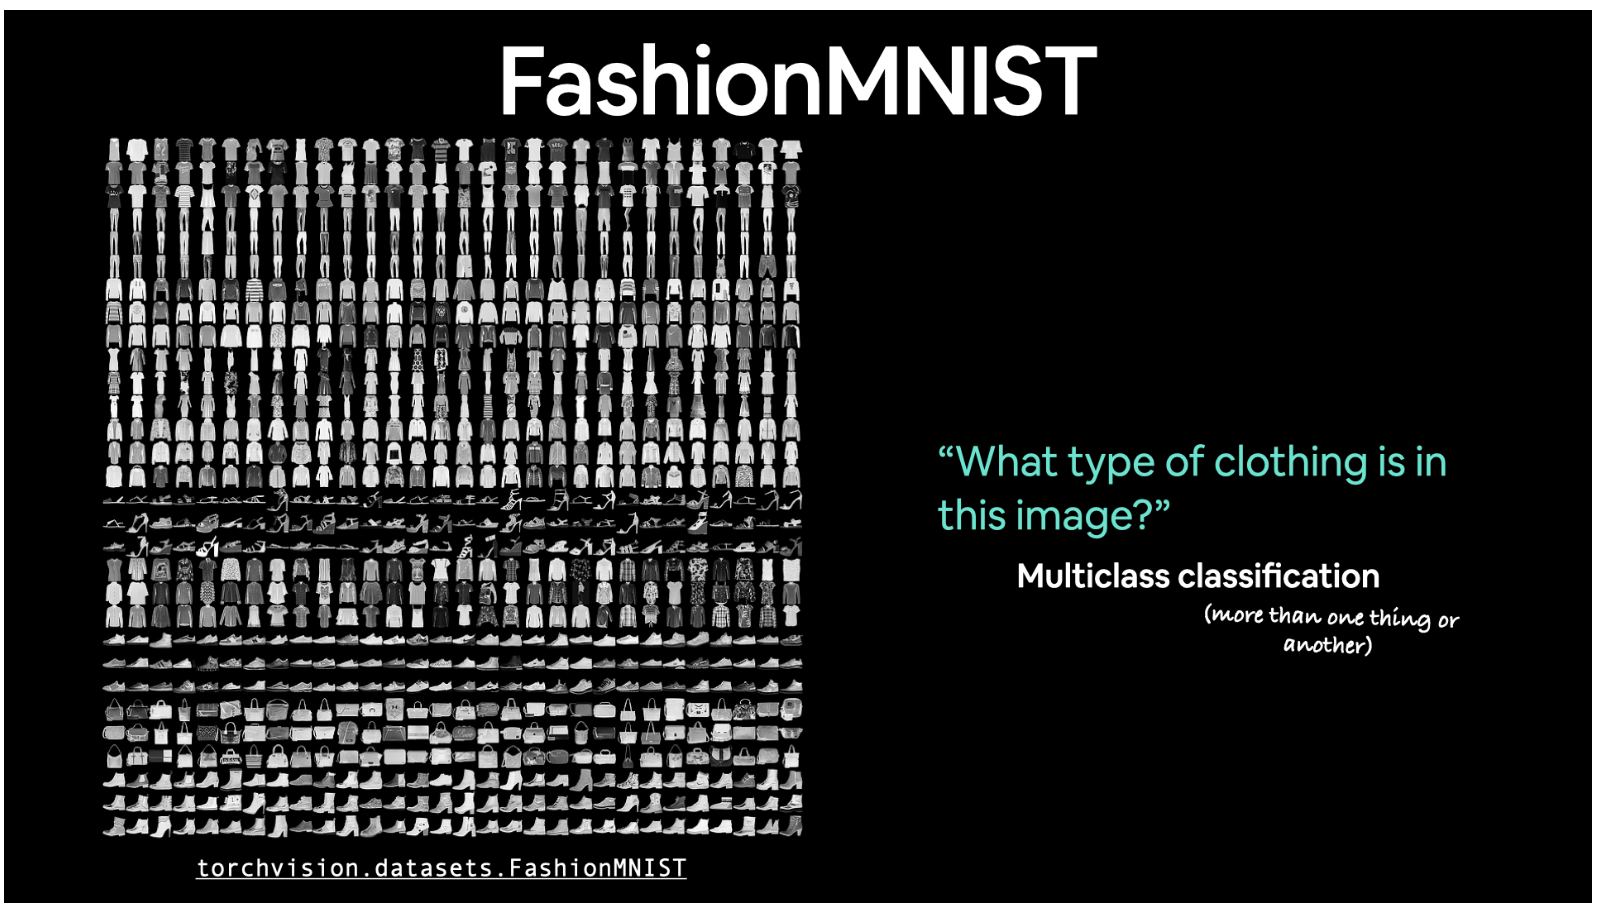

In [ ]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 189kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.53MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.8MB/s]


### 1.1) Input and output shapes of a computer vision model¶


In [ ]:
# See first training sample
image, label = train_data[0]
image, label

image.shape

torch.Size([1, 28, 28])

In [ ]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
# How many samples are there?
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

### 1.2)  Visualising our Data

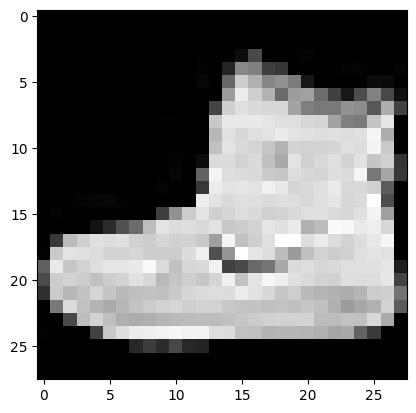

In [ ]:
import matplotlib.pyplot as plt

image, label = train_data[0]
plt.imshow(image.squeeze(), cmap="gray")
plt.show()

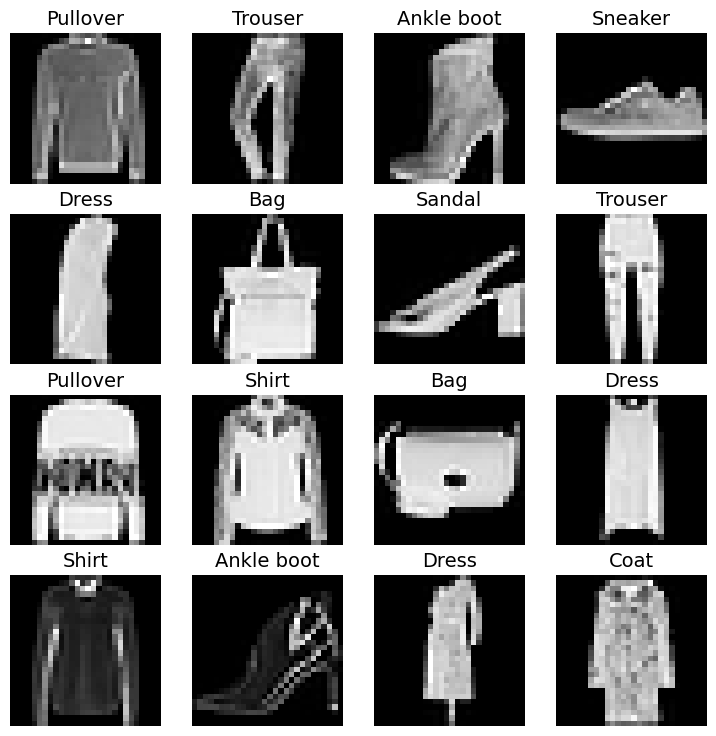

In [ ]:
# Plot more images


fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(class_names[label], fontsize=14)
    plt.axis(False)

## 2) Prepare DataLoader

A data Loader turns our dataset into a python iterable.

More specifically we want to turn our data into mini-batches

Why we do this:

1.   It is more computationally efficient, we may not be able to look at all the data at once.

2.  It gives our NN mroe chances to update its gradients per epoch

In [ ]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7e00b6495310>, <torch.utils.data.dataloader.DataLoader object at 0x7e00b58bc980>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [ ]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

### 2.1) Viewing the Data

Image size: torch.Size([1, 28, 28])
Label: 3, label size: torch.Size([])


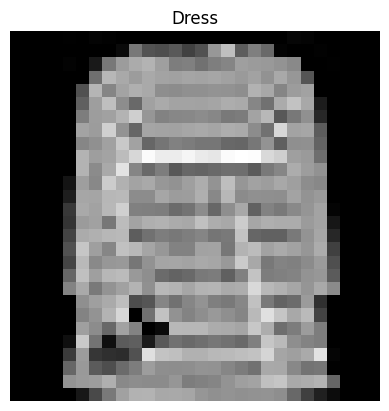

In [ ]:
# Show a sample
# torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3) Building Our First Model

We will start by building a baseline Model, then we improve through experimentation.



In [ ]:
# Create a flatten Model -
flatten_model = nn.Flatten()

X = train_features_batch[0]
output = flatten_model(X)
output.shape # (color channels, height*width)

torch.Size([1, 784])

In [ ]:
from torch import nn

class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )

  def forward(self,x):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=784,
    hidden_units=10,
    output_shape=len(class_names)
)

In [ ]:
dummy_x = torch.rand([1,1,28,28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

### 3.1) Setup Loss Function and Optimizer

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [ ]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

### 3.2) Creating a function to time our experiments

Machine Learning is very experimental.

Two main things we want to track are:

1.  Models Performance
2.  How fast it runs

In [ ]:
from timeit import default_timer as timer

def print_train_time(start:float,
                     end:float,
                     device: torch.device = None):
  total_time = end-start
  print(f"Train Time On {device}: {total_time:.3f} seconds")
  return total_time


In [ ]:
start_time = timer()
end_time =timer()
print_train_time(start=start_time, end=end_time,device="cpu")

Train Time On cpu: 0.000 seconds


4.3546999989985125e-05

## 4) Training Our Model

We will be training our models on batches of data.

1.  Loop through epochs
2.  Loop through training batches, perform training steps, calculate the train loss per batch.
3.  Loop through testing batches, perform testing steps, calculate testing loss per batch.
4.  Print our results and tiem it all at teh same time

In [ ]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")
  #Training
  train_loss = 0
  #Loop to loop through the trainng batches
  for batch, (X,y) in enumerate(train_dataloader):
    model_0.train()

    # Forward Pass
    y_pred = model_0(X)

    # Calculate loss (Per Batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate training loss

    # Optimizer zero grad
    optimizer.zero_grad()

    # Back Prop
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Print out whats happening
    if batch % 400 == 0:
      print(f"Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples")

  # Divide total train loss by total legnth of train data laoder
  train_loss /= len(train_dataloader)

  #Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test,y_test in test_dataloader:
      # Forward Pass
      test_pred = model_0(X_test)
      # Caluclate Loss
      test_loss += loss_fn(test_pred, y_test)
      # Calculate Accuracy
      test_acc += accuracy_fn(y_true=y_test,
                              y_pred=test_pred.argmax(dim=1))
    # Calculate test loss aerage per batch
    test_loss /= len(test_dataloader)
    # Calculate test accuracy aerage per batch
    test_acc /= len(test_dataloader)

  print(f"\nTrain Loss: {train_loss:.5f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%\n")

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                          end=train_time_end_on_cpu,
                                          device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.59039 | Test Loss: 0.50954 | Test Acc: 82.04%

Epoch: 1
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.47633 | Test Loss: 0.47989 | Test Acc: 83.20%

Epoch: 2
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.45503 | Test Loss: 0.47664 | Test Acc: 83.43%

Train Time On cpu: 28.544 seconds


### 4.1) Make predictions and get Model 0 results

In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  """Returns a dictionary containing teh resutlst of model predicting on Data Loader"""
  loss, acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    loss /= len(data_loader)
    acc /= len(data_loader)
  return {"model_name": model.__class__.__name__,
         "model_loss": loss.item(),
         "model_acc": acc}

model_0_results = eval_model(model=model_0,
                              data_loader=test_dataloader,
                              loss_fn=loss_fn,
                              accuracy_fn=accuracy_fn)
model_0_results


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 5) Building Model 1: Building a better model with non-linearity

### 5.1) Setting up device Agnostic Code to Run On GPU

In [ ]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 5.2) Creating Model

Lets Create a Model with Non-Linearity

In [ ]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_shape)
    )
  def forward(self,x):
    return self.layer_stack(x)



### 5.3) Instantiating Model

In [ ]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

### 5.4) Setup Loss, optimizer and evaluation metrics

In [ ]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

### 5.5) Functionising Train and Test Loops

In [ ]:
def train_step(model: torch.nn.Module,
               Data_Loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device
               ):
  train_loss, train_acc = 0,0
  # Put model to training mode
  model.train()
  for batch, (X,y) in enumerate(Data_Loader):
    # Put data on target Device
    X, y = X.to(device), y.to(device)

    # Forward Pass
    y_pred = model(X)

    # Calculate loss & accuracy (Per Batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate training loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    # Optimizer zero grad
    optimizer.zero_grad()

    # Back Prop
    loss.backward()

    # Optimizer step
    optimizer.step()

  # Divide total train loss by total legnth of train data laoder
  train_loss /= len(Data_Loader)
  train_acc /= len(Data_Loader)
  print(f"Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.2f}%")


In [ ]:
def test_step(model: torch.nn.Module,
              Data_Loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  test_loss, test_acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X,y in Data_Loader:
      X, y = X.to(device), y.to(device)

      test_pred = model(X)

      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(Data_Loader)
    test_acc /= len(Data_Loader)
    print(f"Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")


In [ ]:
torch.manual_seed(42)
from timeit import default_timer as timer

train_time_start_on_gpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")
  train_step(model_1,
             train_dataloader,
             loss_fn,
             optimizer,
             accuracy_fn,
             device)

  test_step(model_1,
            test_dataloader,
            loss_fn,
            accuracy_fn,
            device)
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                          end=train_time_end_on_gpu,
                                          device=str(next(model_1.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Train Loss: 0.64607 | Train Acc: 77.17%
Test Loss: 0.53855 | Test Acc: 80.76%
Epoch: 1
------
Train Loss: 0.48094 | Train Acc: 82.94%
Test Loss: 0.49390 | Test Acc: 82.46%
Epoch: 2
------
Train Loss: 0.44689 | Train Acc: 84.16%
Test Loss: 0.45746 | Test Acc: 83.99%
Train Time On cuda:0: 31.338 seconds


In [ ]:
##### WILL NOT WORK, FIX BELOW
# model_1_results = eval_model(model=model_1,
#                              data_loader=test_dataloader,
#                              loss_fn=loss_fn,
#                              accuracy_fn=accuracy_fn)
# model_1_results

RuntimeError: Expected all tensors to be on the same device, but got mat1 is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA_addmm)

In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device = device):
  """Returns a dictionary containing teh resutlst of model predicting on Data Loader"""
  loss, acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      X,y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    loss /= len(data_loader)
    acc /= len(data_loader)
  return {"model_name": model.__class__.__name__,
         "model_loss": loss.item(),
         "model_acc": acc}


In [ ]:
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.45746350288391113,
 'model_acc': 83.98562300319489}

## 6) Building Model 2 (*Convulational Neural Network* )

CNN's are also known as ConvNets.

CNN's are known for thier capabilities to find patterns in visual data.

In [ ]:
class FashionMNISTModelV2(nn.Module):
  """
  Recreating VGG from CNN Explainer https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
        )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
        )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
        )

  def forward(self,x):
    x = self.conv_block_1(x)
    print(x.shape)
    x = self.conv_block_2(x)
    print(x.shape)
    x = self.classifier(x)
    return x



In [ ]:
image.shape

torch.Size([1, 28, 28])

In [ ]:
torch.manual_seed(42)

model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

### 6.1) Stepping through '*nn.Conv2d* '

In [ ]:
torch.manual_seed(42)

# Create sample batch of random numbers with same size as image batch
images = torch.randn(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0] # get a single image for testing
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]")
print(f"Single image pixel values:\n{test_image}")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Single image pixel values:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,

In [ ]:
torch.manual_seed(42)

# Create a convolutional layer with same dimensions as TinyVGG
# (try changing any of the parameters and see what happens)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0) # also try using "valid" or "same" here

# Pass the data through the convolutional layer
conv_layer(test_image)

tensor([[[ 1.5396,  0.0516,  0.6454,  ..., -0.3673,  0.8711,  0.4256],
         [ 0.3662,  1.0114, -0.5997,  ...,  0.8983,  0.2809, -0.2741],
         [ 1.2664, -1.4054,  0.3727,  ..., -0.3409,  1.2191, -0.0463],
         ...,
         [-0.1541,  0.5132, -0.3624,  ..., -0.2360, -0.4609, -0.0035],
         [ 0.2981, -0.2432,  1.5012,  ..., -0.6289, -0.7283, -0.5767],
         [-0.0386, -0.0781, -0.0388,  ...,  0.2842,  0.4228, -0.1802]],

        [[-0.2840, -0.0319, -0.4455,  ..., -0.7956,  1.5599, -1.2449],
         [ 0.2753, -0.1262, -0.6541,  ..., -0.2211,  0.1999, -0.8856],
         [-0.5404, -1.5489,  0.0249,  ..., -0.5932, -1.0913, -0.3849],
         ...,
         [ 0.3870, -0.4064, -0.8236,  ...,  0.1734, -0.4330, -0.4951],
         [-0.1984, -0.6386,  1.0263,  ..., -0.9401, -0.0585, -0.7833],
         [-0.6306, -0.2052, -0.3694,  ..., -1.3248,  0.2456, -0.7134]],

        [[ 0.4414,  0.5100,  0.4846,  ..., -0.8484,  0.2638,  1.1258],
         [ 0.8117,  0.3191, -0.0157,  ...,  1

In [ ]:
abc

# New section